# eda010
osmnxの実現性確認

In [60]:
import os
import pandas as pd
import numpy as np
import ipynb_path
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import plotly
import plotly.express as px
%matplotlib inline
pd.set_option('display.max_rows', 200)

In [61]:
def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [62]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=1000,
                            width=2000)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

In [63]:
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [64]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [65]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [66]:
# reading data
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

In [67]:
base_train['phone'] = base_train['collectionName'] + '_' + base_train['phoneName']
ground_truth['phone'] = ground_truth['collectionName'] + '_' + ground_truth['phoneName']

In [68]:
# ground_truthをもとにした異常値除去を行うcollection
rog_target = ['2021-04-22-US-SJC-1', '2021-04-29-US-SJC-2', '2021-04-28-US-SJC-1', '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3',
              '2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', '2021-03-16-US-RWC-2', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2']

In [69]:
# rog_target以外を抽出
test = base_test[~base_test['collectionName'].isin(rog_target)].copy()

In [70]:
gt.collectionName.unique()

array(['2020-05-14-US-MTV-1', '2020-05-14-US-MTV-2',
       '2020-05-21-US-MTV-1', '2020-05-21-US-MTV-2',
       '2020-05-29-US-MTV-1', '2020-05-29-US-MTV-2',
       '2020-06-04-US-MTV-1', '2020-06-05-US-MTV-1',
       '2020-06-05-US-MTV-2', '2020-06-11-US-MTV-1',
       '2020-07-08-US-MTV-1', '2020-07-17-US-MTV-1',
       '2020-07-17-US-MTV-2', '2020-08-03-US-MTV-1',
       '2020-08-06-US-MTV-2', '2020-09-04-US-SF-1', '2020-09-04-US-SF-2',
       '2021-01-04-US-RWC-1', '2021-01-04-US-RWC-2',
       '2021-01-05-US-SVL-1', '2021-01-05-US-SVL-2',
       '2021-03-10-US-SVL-1', '2021-04-15-US-MTV-1',
       '2021-04-26-US-SVL-1'], dtype=object)

In [71]:
test.collectionName.unique()

array(['2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1',
       '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
       '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2',
       '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
       '2021-03-16-US-MTV-2', '2021-03-25-US-PAO-1',
       '2021-04-02-US-SJC-1', '2021-04-08-US-MTV-1',
       '2021-04-21-US-MTV-1', '2021-04-26-US-SVL-2'], dtype=object)

In [72]:
def remove_based_on_gt(target_df, target_gt, th):
    for idx in target_df.index:
        lat = target_df.at[idx, 'latDeg']
        lng = target_df.at[idx, 'lngDeg']
        s = target_df.at[idx, 'millisSinceGpsEpoch']
        
        if np.isnan(lat):
            continue
        else:
            target_gt['latDeg_pred'] = lat
            target_gt['lngDeg_pred'] = lng
            target_gt['dist'] = calc_haversine(target_gt['latDeg'], target_gt['lngDeg'], target_gt['latDeg_pred'], target_gt['lngDeg_pred'])
            closest_dist = target_gt['dist'].min()
            if closest_dist > th:
                target_df.at[idx, 'latDeg'] = np.nan
                target_df.at[idx, 'lngDeg'] = np.nan
    return target_df

In [78]:
rog = test[test['collectionName']=='2021-04-21-US-MTV-1'].copy()
rog = remove_based_on_gt(rog, ground_truth, 10)

In [79]:
idx = rog[rog['latDeg'].isnull()].index
rog_test = test.loc[idx]

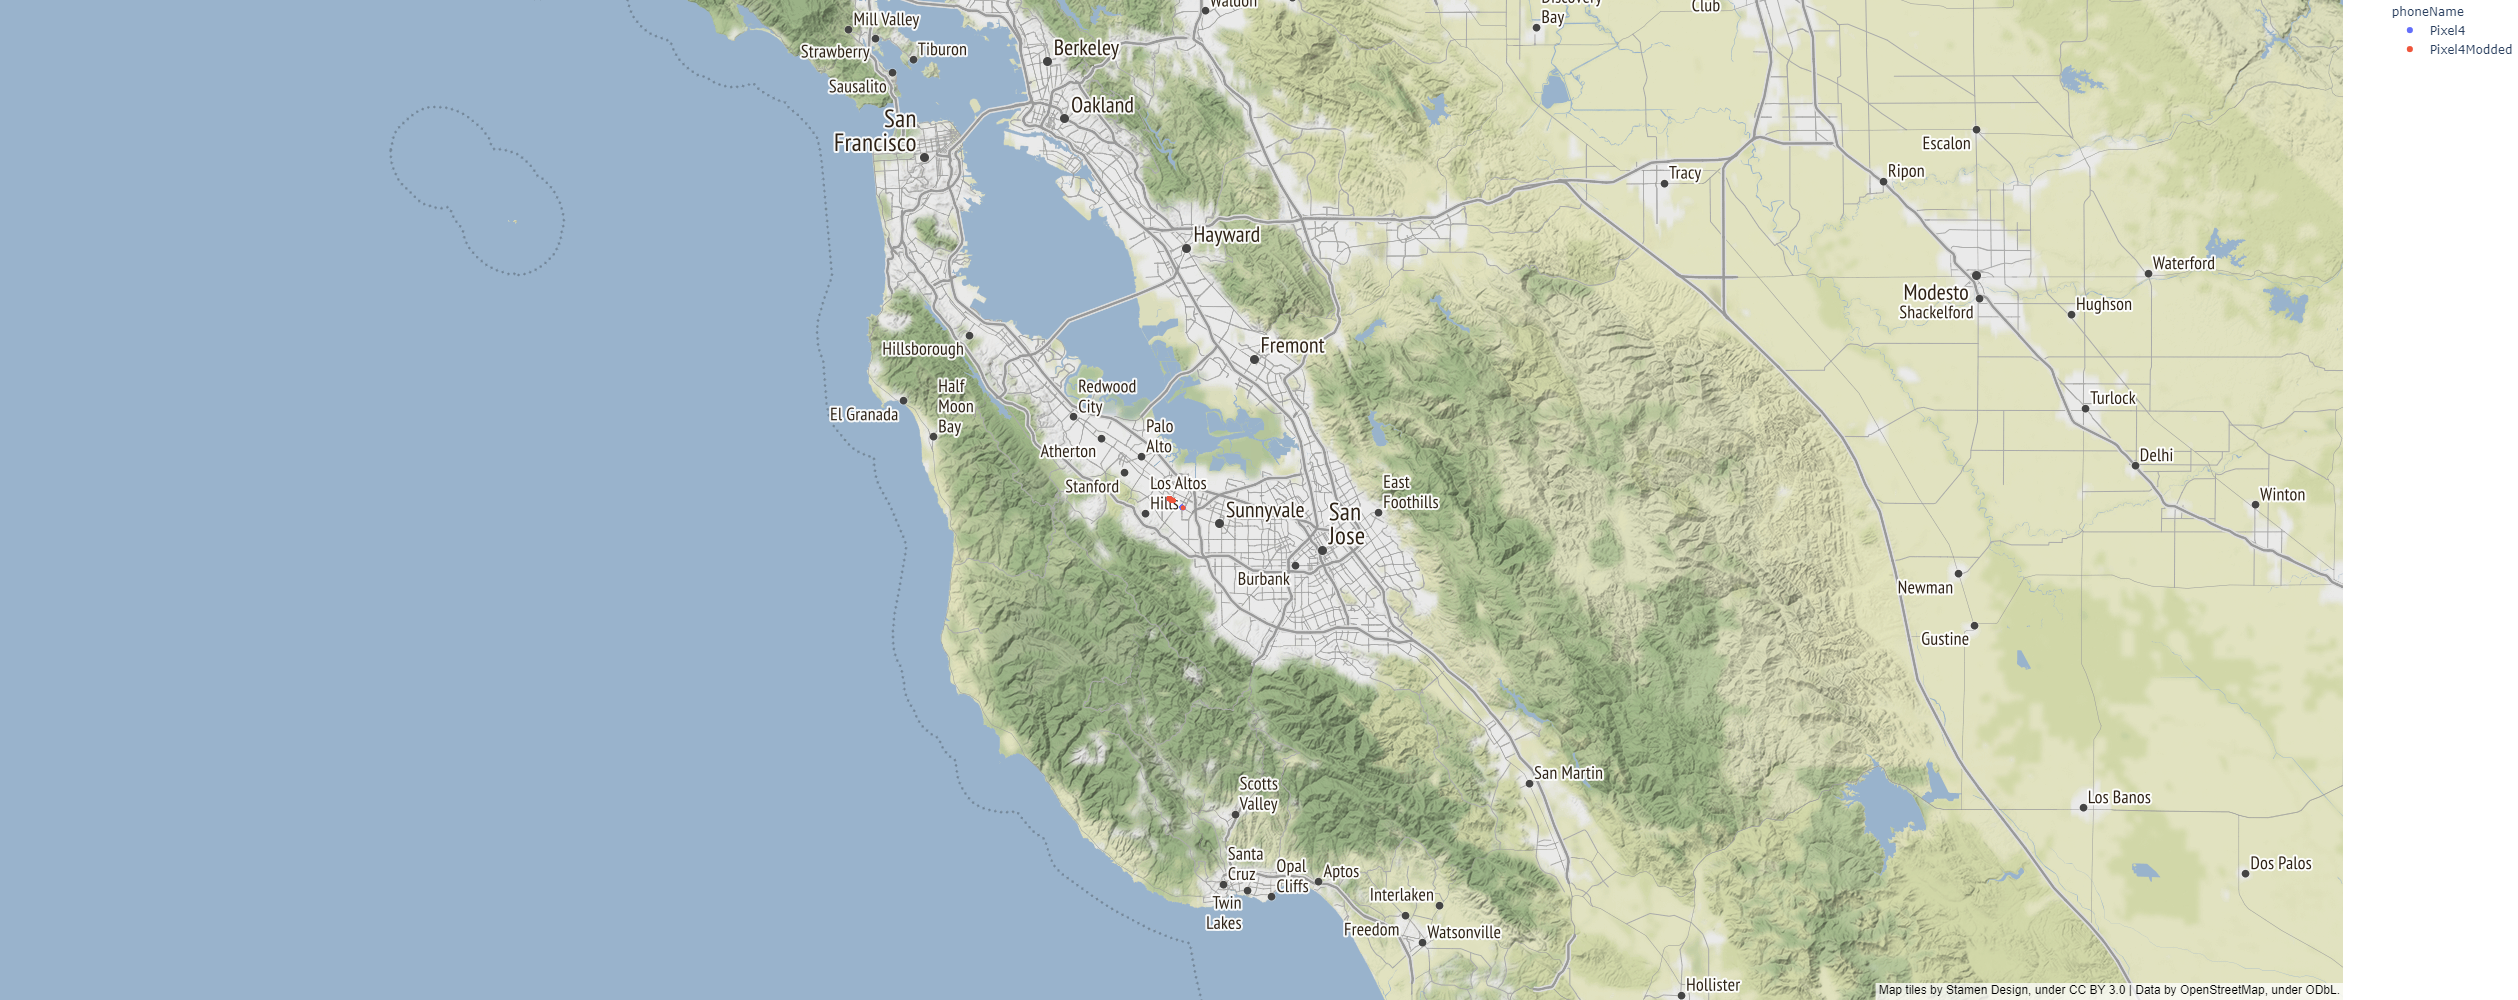

In [80]:
visualize_collection(rog_test, '2021-04-21-US-MTV-1')